In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install tensorflow-addons

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow import keras
import os
import cv2
from sklearn.utils import shuffle

In [ ]:
from torchvision import transforms

def random_rotate(image):
  return transforms.RandomRotation(degrees=(-45, 45))(image)

import numpy as np

def add_gaussian_noise(image, mean=0, std=1.0):
    return image + np.random.normal(mean, std, image.shape)

def flip_random_crop(image):
    # With random crops we also apply horizontal flipping.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 1))
    return image


def color_jitter(x, strength=[0.4, 0.4, 0.4, 0.1]):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength[0])
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength[1], upper=1 + 0.8 * strength[1]
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength[2], upper=1 + 0.8 * strength[2]
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength[3])
    # Affine transformations can disturb the natural range of
    # RGB images, hence this is needed.
    x = tf.clip_by_value(x, 0, 255)
    return x

def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x

def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x

def random_brightness(image, max_delta=0.5):
    img_array = tf.expand_dims(image, 0)
    img_array = tf.image.random_brightness(img_array, max_delta=max_delta)
    return tf.squeeze(img_array, axis=0)

def random_contrast(image, lower=0.2, upper=1.8):
    img_array = tf.expand_dims(image, 0)
    img_array = tf.image.random_contrast(img_array, lower=lower, upper=upper)
    return tf.squeeze(img_array, axis=0)

def random_noise(image, stddev=0.2):
    img_array = tf.expand_dims(image, 0)
    noise = tf.random.normal(shape=tf.shape(img_array), mean=0.0, stddev=stddev)
    img_array = tf.add(tf.cast(img_array, tf.float32), noise)
    return tf.cast(tf.squeeze(img_array, axis=0), tf.float64)

def random_noise_2(image, stddev=0.005):
    img_array = tf.expand_dims(image, 0)
    noise = tf.random.normal(shape=tf.shape(img_array), mean=0.0, stddev=stddev)
    img_array = tf.add(tf.cast(img_array, tf.float32), noise)
    return tf.cast(tf.squeeze(img_array, axis=0), tf.float64)


def custom_augment1(image):
    image = random_noise(image)
    image = random_apply(color_jitter, image, p=0.4)
    image = random_contrast(image, lower=0.2, upper=1.8)
    return image

def custom_augment2(image):
    image = random_noise_2(image)
    image = random_apply(flip_random_crop, image, p=0.4)
    image = random_contrast(image, lower=0.2, upper=1.8)
    return image

In [ ]:
!pip install open3d

In [ ]:
import os, cv2, pandas as pd, numpy as np
import open3d as o3d

In [ ]:
def register_point_clouds(source, target):
    # Downsample for faster registration (optional)
    source_down = source.voxel_down_sample(voxel_size=0.05)
    target_down = target.voxel_down_sample(voxel_size=0.05)
    # Perform ICP registration
    threshold = 0.02
    trans_init = np.identity(4)
    reg_p2p = o3d.pipelines.registration.registration_icp(
        source_down, target_down, threshold, trans_init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint()
    )
    # Apply the transformation to align the source point cloud with the target
    source.transform(reg_p2p.transformation)
    return source

In [ ]:
D, DATA, K = [], [], 1
for image_files, depth_files, PC_files in zip(sorted(os.listdir('/content/drive/MyDrive/+---¦·¦+-º+¦-¦8¦++¦+¦¦++»-²+¦.2023.6 (1).13/image')), sorted(os.listdir('/content/drive/MyDrive/+---¦·¦+-º+¦-¦8¦++¦+¦¦++»-²+¦.2023.6 (1).13/depth')), sorted(os.listdir('/content/drive/MyDrive/+---¦·¦+-º+¦-¦8¦++¦+¦¦++»-²+¦.2023.6 (1).13/point cloud'))):
  Image  = cv2.imread(f'/content/drive/MyDrive/+---¦·¦+-º+¦-¦8¦++¦+¦¦++»-²+¦.2023.6 (1).13/image/{image_files}')
  Image = cv2.resize(Image, (128,128))
  Image = (Image-Image.min())/(Image.max()-Image.min())
  Depth  = cv2.imread(f'/content/drive/MyDrive/+---¦·¦+-º+¦-¦8¦++¦+¦¦++»-²+¦.2023.6 (1).13/depth/{depth_files}', cv2.IMREAD_ANYDEPTH)
  Depth = cv2.resize(Depth, (128,128))
  Depth = (Depth-Depth.min())/(Depth.max()-Depth.min())
  Point_Cloud = o3d.io.read_point_cloud(f'/content/drive/MyDrive/+---¦·¦+-º+¦-¦8¦++¦+¦¦++»-²+¦.2023.6 (1).13/point cloud/{PC_files}')
  voxel_size = 0.05  # Adjust the voxel size according to your needs
  downsampled_cloud = Point_Cloud.voxel_down_sample(voxel_size=voxel_size)
  if K!=1:
    downsampled_cloud = register_point_clouds(D[0], Point_Cloud)
  points = np.asarray(downsampled_cloud.points)
  # points = (points-points.min())/(points.max()-points.min())
  DATA.append((Image, Depth, points))
  D.append(downsampled_cloud)
  K+=1
DATA = np.array(DATA)

<ipython-input-8-4dc99972e0b3>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  DATA = np.array(DATA)


In [ ]:
Images = np.array([i for i in DATA[:,0]]).reshape((29, 128, 128,3))
Depth = np.array([i for i in DATA[:,1]]).reshape((29, 128, 128, 1))
Point_Cloud = np.array([i for i in DATA[:,2]]).reshape((29, 369, 3))
x_train_img, x_test_img, x_train_dpt, y_test_dpt, y_train, y_test = Images[:20], Images[20:], Depth[:20], Depth[20:], Point_Cloud[:20], Point_Cloud[20:]
x_train_img.shape, x_test_img.shape, x_train_dpt.shape, y_test_dpt.shape, y_train.shape, y_test.shape

((20, 128, 128, 3),
 (9, 128, 128, 3),
 (20, 128, 128, 1),
 (9, 128, 128, 1),
 (20, 369, 3),
 (9, 369, 3))

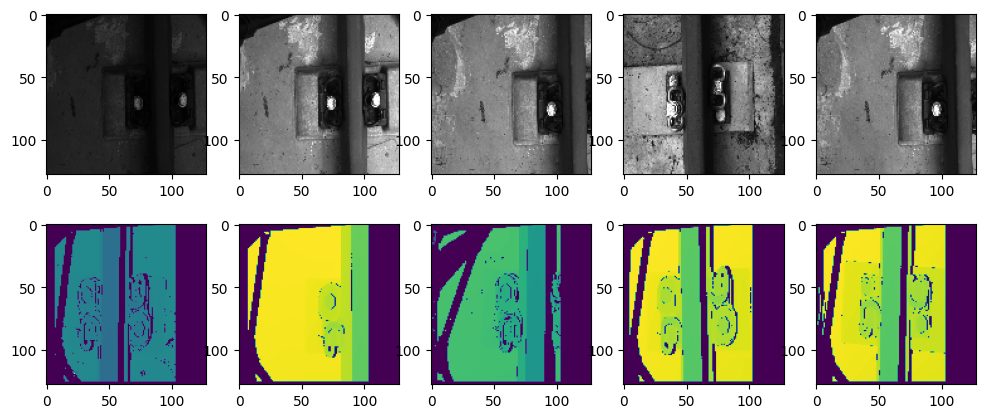

In [ ]:
plt.rcParams['figure.figsize']=(12,5)
plt.subplot(2,5,1)
plt.imshow(x_train_img[0])
plt.subplot(2,5,2)
plt.imshow(x_train_img[1])
plt.subplot(2,5,3)
plt.imshow(x_train_img[2])
plt.subplot(2,5,4)
plt.imshow(x_train_img[3])
plt.subplot(2,5,5)
plt.imshow(x_train_img[4])

plt.subplot(2,5,6)
plt.imshow(x_train_dpt[0])
plt.subplot(2,5,7)
plt.imshow(x_train_dpt[1])
plt.subplot(2,5,8)
plt.imshow(x_train_dpt[2])
plt.subplot(2,5,9)
plt.imshow(x_train_dpt[3])
plt.subplot(2,5,10)
plt.imshow(x_train_dpt[4])

plt.show()



In [ ]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 50
EPOCHS = 5
CROP_TO = 128
SEED = 26

PROJECT_DIM = 2
LATENT_DIM = 512
WEIGHT_DECAY = 0.0005

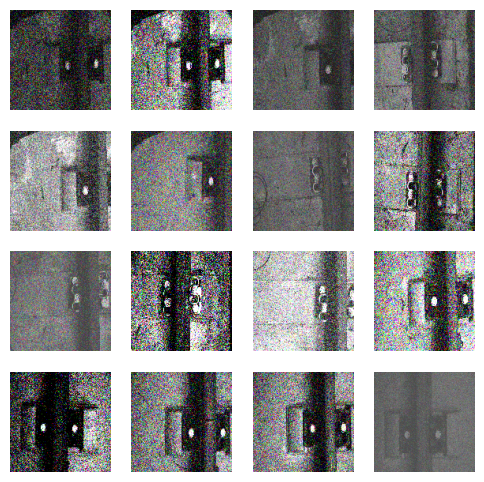

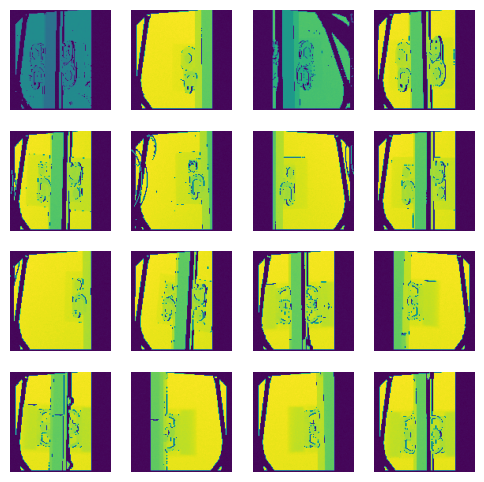

In [ ]:
ssl_ds_one = tf.data.Dataset.from_tensor_slices(x_train_img).batch(BATCH_SIZE).prefetch(AUTO)
ssl_ds_two = tf.data.Dataset.from_tensor_slices(x_train_img).map(custom_augment1, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)

ssl_ds_three = tf.data.Dataset.from_tensor_slices(x_train_dpt).batch(BATCH_SIZE).prefetch(AUTO)
ssl_ds_four = tf.data.Dataset.from_tensor_slices(x_train_dpt).map(custom_augment2, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)

ssl_ds_PC = tf.data.Dataset.from_tensor_slices(y_train)
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two, ssl_ds_three, ssl_ds_four))

# Visualize a few augmented images.
sample_images_one = next(iter(ssl_ds_two))
plt.figure(figsize=(6, 6))
for n in range(16):
    ax = plt.subplot(4, 4, n + 1)
    plt.imshow(sample_images_one[n].numpy())
    plt.axis("off")
plt.show()

# Ensure that the different versions of the dataset actually contain
# identical images.
sample_images_two = next(iter(ssl_ds_four))
plt.figure(figsize=(6, 6))
for n in range(16):
    ax = plt.subplot(4, 4, n + 1)
    plt.imshow(sample_images_two[n].numpy())
    plt.axis("off")
plt.show()

In [ ]:
ssl_ds_one = tf.data.Dataset.from_tensor_slices(x_train_img).batch(1).prefetch(AUTO)
ssl_ds_two = tf.data.Dataset.from_tensor_slices(x_train_img).map(custom_augment1, num_parallel_calls=AUTO).batch(1).prefetch(AUTO)

ssl_ds_three = tf.data.Dataset.from_tensor_slices(x_train_dpt).batch(1).prefetch(AUTO)
ssl_ds_four = tf.data.Dataset.from_tensor_slices(x_train_dpt).map(custom_augment2, num_parallel_calls=AUTO).batch(1).prefetch(AUTO)

ssl_ds_PC = tf.data.Dataset.from_tensor_slices(y_train).batch(1).prefetch(AUTO)
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two, ssl_ds_three, ssl_ds_four, ssl_ds_PC))

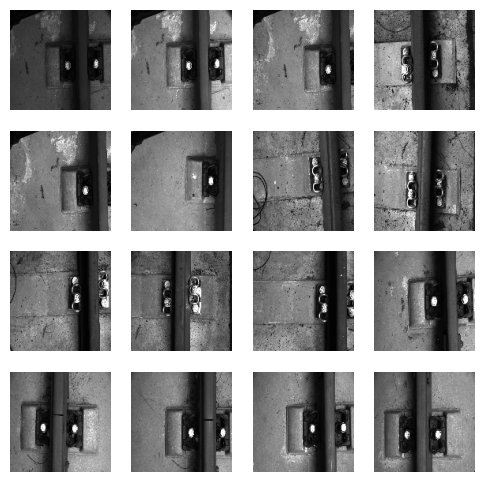

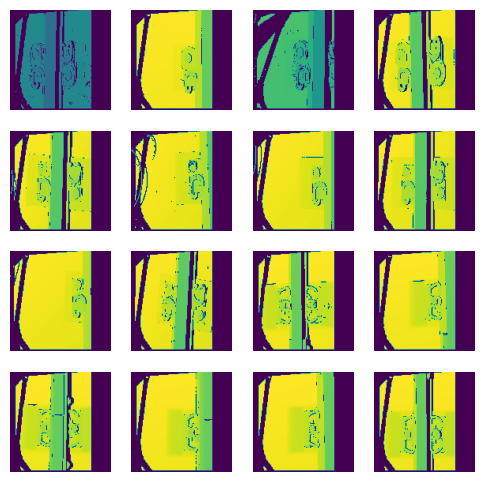

In [ ]:
# Visualize a few augmented images.
sample_images_one = next(iter(ssl_ds_one))
plt.figure(figsize=(6, 6))
for n in range(16):
    ax = plt.subplot(4, 4, n + 1)
    plt.imshow(sample_images_one[n].numpy())
    plt.axis("off")
plt.show()

# Ensure that the different versions of the dataset actually contain
# identical images.
sample_images_two = next(iter(ssl_ds_three))
plt.figure(figsize=(6, 6))
for n in range(16):
    ax = plt.subplot(4, 4, n + 1)
    plt.imshow(sample_images_two[n].numpy())
    plt.axis("off")
plt.show()

Image size: 128 X 128
Patch size: 8 X 8
Patches per image: 256
Elements per patch: 192


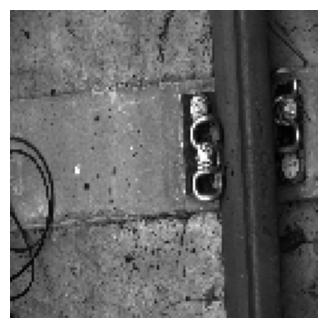

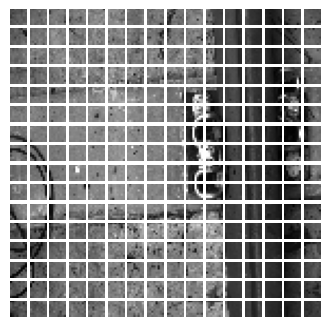

In [ ]:
image_size = 128
patch_size = 8
num_patches = (image_size // patch_size) ** 2
projection_dim = 16
num_heads = 4
transformer_units = [projection_dim * 2,projection_dim]  # Size of the transformer layers
transformer_layers = 4
mlp_head_units = [64, 128]


data_augmentation = keras.Sequential([layers.Normalization(),layers.Resizing(image_size, image_size),layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),layers.RandomZoom(height_factor=0.2, width_factor=0.2)],name="data_augmentation")

embedding_dim = 64

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train_img[np.random.choice(range(x_train_img.shape[0]))]
plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim)
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=(128, 128, 3))
    # patches = T_Patches(patch_size)(augmented)
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])
    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    model = keras.Model(inputs=inputs, outputs=representation)
    return model

TRANFORMER_ENCODER = create_vit_classifier()

In [ ]:
TRANFORMER_ENCODER.summary()

Model: "model_53"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_84 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 patches_22 (Patches)        (None, None, 192)            0         ['input_84[0][0]']            
                                                                                                  
 patch_encoder_20 (PatchEnc  (None, 256, 16)              7184      ['patches_22[0][0]']          
 oder)                                                                                            
                                                                                                  
 layer_normalization_110 (L  (None, 256, 16)              32        ['patch_encoder_20[0][0

In [ ]:
TRANFORMER_ENCODER(tf.random.uniform((1,128,128,3)))

<tf.Tensor: shape=(1, 4096), dtype=float32, numpy=
array([[-1.0173364 ,  0.7856366 , -0.18542618, ...,  1.4039259 ,
        -2.1730964 ,  0.8378249 ]], dtype=float32)>

In [ ]:
!pip install -U tensorflow-addons

In [ ]:
import tensorflow_addons as tfa

embedding_dim_ = 16

def BUILD(blocks, positional_encoding=True):
    inputs = layers.Input(shape=(128,128,1))
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    patches = PatchEncoder(num_patches, embedding_dim_)(patches)
    x = layers.Dense(units=embedding_dim_)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = layers.Embedding(input_dim=num_patches, output_dim=embedding_dim_)(positions)
        x = x + position_embedding
    x = blocks(x)
    return keras.Model(inputs=inputs, outputs=x)


class FNetLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super(FNetLayer, self).__init__(*args, **kwargs)
        self.ffn = keras.Sequential([layers.Dense(units=embedding_dim),tfa.layers.GELU(),layers.Dropout(rate=dropout_rate),
                layers.Dense(units=embedding_dim)])
        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)
        self.flat = keras.layers.Flatten()
    def call(self, inputs):
        x = tf.cast(tf.signal.fft2d(tf.cast(inputs, dtype=tf.dtypes.complex64)),dtype=tf.dtypes.float32)
        x = x + inputs
        x = self.normalize1(x)
        x_ffn = self.ffn(x)
        x = x + x_ffn
        return self.flat(self.normalize2(x))
# FREQUENCY FEATURES

class FNet:
  def __init__(self):
    pass
  def FourierMLP_Embedding(self, x, dropout_rate, patch_size=4, image_size=28):
      num_patches = (image_size // patch_size) ** 2
      mlpmixer_blocks = keras.Sequential([FNetLayer(num_patches, embedding_dim_, dropout_rate)])
      FeatureExtraction = BUILD(mlpmixer_blocks)
      return  FeatureExtraction(x)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
FNet().FourierMLP_Embedding(tf.random.uniform((1,128,128,1)),0.2)

<tf.Tensor: shape=(1, 4096), dtype=float32, numpy=
array([[ 0.41212642,  1.2775657 ,  0.85879654, ...,  1.6577886 ,
        -0.5979295 ,  0.7787334 ]], dtype=float32)>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def squeeze_excitation_block(x, ratio=8):
    channels = x.shape[-1]
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(channels // ratio, activation='relu')(se)
    se = layers.Dense(channels, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, channels))(se)
    x = layers.Multiply()([x, se])
    return x

def create_dual_stream_attention_network(input_shape_rgb, input_shape_depth):
    # RGB Stream
    rgb_input = layers.Input(shape=input_shape_rgb, name='rgb_input')
    rgb_features = models.Sequential([
        layers.Conv2D(32, (3, 3),padding='same'), keras.layers.LeakyReLU(alpha=0.3),
        keras.layers.MaxPooling2D((2,2)),
        layers.Conv2D(16, (3, 3),padding='same'), keras.layers.LeakyReLU(alpha=0.3),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.BatchNormalization(),
        layers.SeparableConv2D(16, (3, 3), padding='same'), keras.layers.LeakyReLU(alpha=0.3),
        layers.DepthwiseConv2D(16, (3, 3), padding='same'), keras.layers.LeakyReLU(alpha=0.3),
        keras.layers.BatchNormalization(),
        layers.Conv2D(16, (3, 3),  padding='same'), keras.layers.LeakyReLU(alpha=0.3),
        keras.layers.MaxPooling2D((2,2)),
        layers.Conv2D(8, (3, 3),  padding='same'), keras.layers.LeakyReLU(alpha=0.3)
    ])(rgb_input)

    # Depth Stream
    depth_input = layers.Input(shape=input_shape_depth, name='depth_input')
    depth_features = models.Sequential([
         layers.Conv2D(32, (3, 3),padding='same'), keras.layers.LeakyReLU(alpha=0.3),
         keras.layers.MaxPooling2D((2,2)),
        layers.Conv2D(16, (3, 3),padding='same'), keras.layers.LeakyReLU(alpha=0.3),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.BatchNormalization(),
        layers.SeparableConv2D(16, (3, 3), padding='same'), keras.layers.LeakyReLU(alpha=0.3),
        layers.DepthwiseConv2D(16, (3, 3), padding='same'), keras.layers.LeakyReLU(alpha=0.3),
        keras.layers.BatchNormalization(),
        layers.Conv2D(16, (3, 3),  padding='same'), keras.layers.LeakyReLU(alpha=0.3),
        keras.layers.MaxPooling2D((2,2)),
        layers.Conv2D(8, (3, 3),  padding='same'), keras.layers.LeakyReLU(alpha=0.3)
    ])(depth_input)

    # Concatenate RGB and Depth features
    merged_features = layers.average([rgb_features, depth_features])
    # Apply Squeeze-and-Excitation attention mechanism
    attention_fusion = squeeze_excitation_block(merged_features)
    Flat = keras.layers.Flatten()(attention_fusion)
    Reperesentation = layers.Dense(4096, activation='relu')(Flat)
    # Final layers for classification
    # Create the model
    model = models.Model(inputs=[rgb_input, depth_input], outputs=Reperesentation)

    return model

# Example usage
input_shape_rgb = (128, 128, 3)
input_shape_depth = (128, 128, 1)
num_classes = 10  # Adjust based on your task

model = create_dual_stream_attention_network(input_shape_rgb, input_shape_depth)

In [ ]:
model([tf.random.uniform((1,128,128,3)), tf.random.uniform((1,128,128,1))])


<tf.Tensor: shape=(1, 4096), dtype=float32, numpy=
array([[5.6420325e-04, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        6.1366467e-05, 3.2837098e-04]], dtype=float32)>

In [ ]:
model.summary()

Model: "model_54"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 rgb_input (InputLayer)      [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 depth_input (InputLayer)    [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 sequential_40 (Sequential)  (None, 5, 5, 8)              13656     ['rgb_input[0][0]']           
                                                                                                  
 sequential_41 (Sequential)  (None, 5, 5, 8)              13080     ['depth_input[0][0]']         
                                                                                           

In [ ]:
def get_encoder():

    INP_IMG = keras.layers.Input(shape=(128,128,3))
    DPT_IMG = keras.layers.Input(shape=(128,128,1))

    TRANFORMER_ENCODER = create_vit_classifier()
    Images_featrures = TRANFORMER_ENCODER(INP_IMG)
    Images_featrures = keras.activations.relu(Images_featrures)
#------------------------------------------------------- (4096)
    FourierNet= FNet()
    Depth_featrures= FourierNet.FourierMLP_Embedding(DPT_IMG, 0.2)
    Depth_featrures = keras.activations.relu(Depth_featrures)
#------------------------------------------------------- (4096)
    model = create_dual_stream_attention_network(input_shape_rgb, input_shape_depth)
    Mixtures_Features = model([INP_IMG,DPT_IMG])

    # Multi-modal fusion using attention mechanism
    attentioned_features = layers.Attention()([Images_featrures, Depth_featrures, Mixtures_Features])

    return keras.models.Model([INP_IMG, DPT_IMG], [Images_featrures,Depth_featrures,Mixtures_Features, attentioned_features])


def residual_block(iNP, units, activation='relu'):
    # Simple residual block with a dense layer and activation function
    x = layers.Dense(units, activation=activation)(iNP)
    y = layers.Dense(units, activation=activation)(x)  # No activation for the second layer
    return layers.Add()([x, y])  # Add the input to the output


def get_predictor():
  input_features = layers.Input(shape=(4096,), name='input_features')
  # Dense layers with residual connections
  dense1 = residual_block(input_features, 256, activation='relu')
  dense2 = residual_block(dense1, 128, activation='relu')
  dense3 = residual_block(dense2, 256, activation='relu')
  output_features = layers.Dense(4096, activation='relu')(dense3)
  decoder_model = models.Model(inputs=input_features, outputs=output_features, name='decoder_model')
  return decoder_model


In [ ]:
MM = get_predictor()
MM(tf.random.uniform((1,4096)))

<tf.Tensor: shape=(1, 4096), dtype=float32, numpy=
array([[0.        , 0.2030369 , 0.        , ..., 0.08621596, 0.        ,
        0.25736788]], dtype=float32)>

In [ ]:
import tensorflow_probability as tfp
tfpl = tfp.layers

def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return lambda t: tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros(n, dtype=dtype),
                                                scale=1),
                                     reinterpreted_batch_ndims=1)

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return keras.models.Sequential([
        tfp.layers.VariableLayer(tfp.layers.IndependentNormal.params_size(n), dtype=dtype),
        tfp.layers.IndependentNormal(n)
    ])
Exact_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q,
                                                          p) / Images.shape[0]
def approximate_kl(q, p, q_tensor):
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))
Approx_divergence_fn = lambda q, p, q_tensor : approximate_kl(q, p,
                                                      q_tensor) / Images.shape[0]

In [ ]:
def POINT_CLOUD():
    I_Z1 = keras.layers.Input(shape=[4096])
    D_Z2 = keras.layers.Input(shape=[4096])
    A_Z2 = keras.layers.Input(shape=[4096])

    bayesian_I_Z1_1 = tfpl.DenseVariational(units=128, make_prior_fn=prior, make_posterior_fn=posterior, activation='relu' )(I_Z1)
    BPC_Img = tfpl.DenseVariational(units=369*3,make_prior_fn=prior,make_posterior_fn=posterior, activation='relu' )(bayesian_I_Z1_1)

    bayesian_D_Z1_1 = tfpl.DenseVariational(units=128, make_prior_fn=prior, make_posterior_fn=posterior, activation='relu' )(D_Z2)
    BPC_Dpt = tfpl.DenseVariational(units=369*3,make_prior_fn=prior,make_posterior_fn=posterior, activation='relu' )(bayesian_D_Z1_1)

    bayesian_Att = tfpl.DenseVariational(units=128, make_prior_fn=prior, make_posterior_fn=posterior, activation='relu' )(A_Z2)
    BPC_Att = tfpl.DenseVariational(units=369*3,make_prior_fn=prior,make_posterior_fn=posterior, activation='relu' )(bayesian_Att)

    # Trainable coefficients for linear combination
    coefficients = tf.Variable(initial_value=tf.constant([1.0, 1.0, 1.0]), trainable=True)
    weighted_sum = tf.math.add_n([BPC_Img * coefficients[0], BPC_Dpt * coefficients[1], BPC_Att * coefficients[2]])
    # Sample from the mixture
    reshaped_output = tf.reshape(weighted_sum, (369, 3))

    model = models.Model(inputs=[I_Z1, D_Z2, A_Z2], outputs=reshaped_output)
    return model


In [ ]:
pc = POINT_CLOUD()
U = pc([tf.random.uniform((1,4096)), tf.random.uniform((1,4096)), tf.random.uniform((1,4096))])

In [ ]:
U

<tf.Tensor: shape=(369, 3), dtype=float32, numpy=
array([[  0.       ,  28.099123 ,   0.       ],
       [267.5621   , 111.02319  ,  12.998108 ],
       [ 57.655296 ,  80.58585  ,  51.77098  ],
       ...,
       [ 60.614098 ,  81.75937  ,   5.320686 ],
       [244.13062  ,   3.0053217, 127.97336  ],
       [  0.       , 342.28915  ,  38.069454 ]], dtype=float32)>

In [ ]:
!pip install pyntcloud

In [ ]:
import pyntcloud

/usr/local/lib/python3.10/dist-packages/pyntcloud/utils/numba.py:5: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def groupby_count(xyz, indices, out):
/usr/local/lib/python3.10/dist-packages/pyntcloud/utils/numba.py:12: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def groupby_sum(xyz, indices, N, out):
/usr/local/lib/python3.10/dist-packages/pyntcloud/utils/nu

In [ ]:
import pandas as pd
d = pd.DataFrame(U)
d.columns = ['x', 'y', 'z']
d.head()

,x,y,z
0,1.0,1.0,1.000000
1,1.0,1.0,1.000000
2,1.0,0.5,0.938284
3,1.0,1.0,1.000000
4,1.0,1.0,1.000000


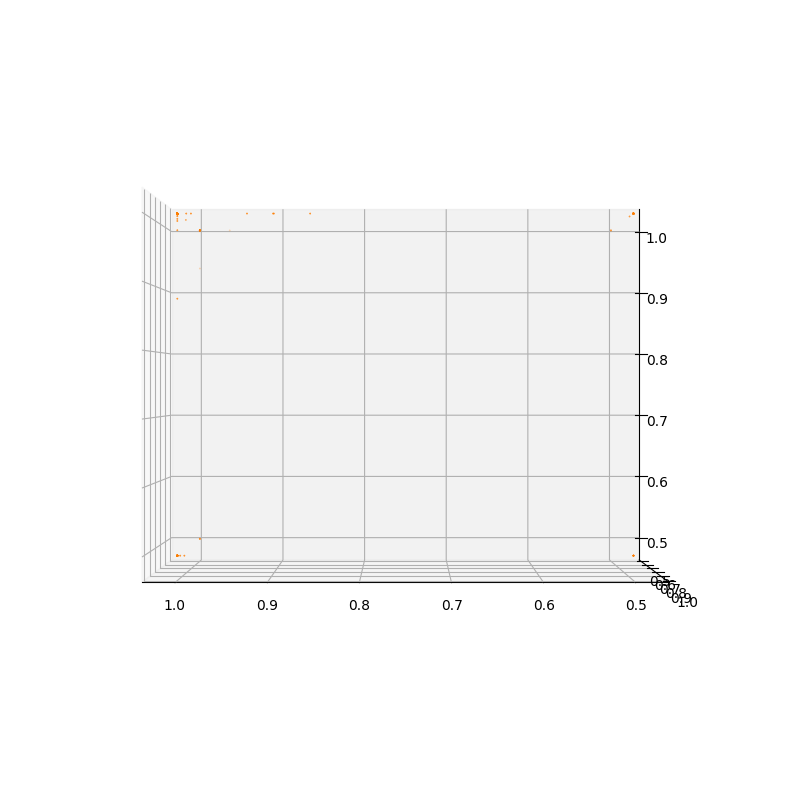

In [ ]:
cloud = pyntcloud.PyntCloud(d)
# Create a 3D scatter plot of the point cloud
scatter = cloud.plot(use_as_color="scalar", cmap="viridis")
scatter

In [ ]:
MDLJ = get_encoder()

In [ ]:
hdjs = MDLJ([tf.random.uniform((1,128,128,3)), tf.random.uniform((1,128,128,1))])

In [ ]:
hdjs

[<tf.Tensor: shape=(1, 4096), dtype=float32, numpy=
 array([[1.4810274 , 1.6446805 , 0.20004421, ..., 0.        , 0.        ,
         0.57598954]], dtype=float32)>,
 <tf.Tensor: shape=(1, 4096), dtype=float32, numpy=
 array([[2.3712382 , 0.        , 0.03020962, ..., 0.        , 1.3941547 ,
         0.7204306 ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 4096), dtype=float32, numpy=
 array([[0.0000000e+00, 3.7342831e-04, 1.4914693e-04, ..., 8.7422412e-04,
         8.2495098e-05, 0.0000000e+00]], dtype=float32)>,
 <tf.Tensor: shape=(1, 4096), dtype=float32, numpy=
 array([[2.3712382 , 0.        , 0.03020962, ..., 0.        , 1.3941547 ,
         0.7204306 ]], dtype=float32)>]

In [ ]:
MDLJ.summary()

Model: "model_107"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_171 (InputLayer)      [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_172 (InputLayer)      [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 model_104 (Functional)      (None, 4096)                 28976     ['input_171[0][0]']           
                                                                                                  
 model_105 (Functional)      (None, 4096)                 6016      ['input_172[0][0]']           
                                                                                          

In [ ]:
def compute_loss(p, z):
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    return -tf.reduce_mean(tf.reduce_sum((p * z), axis=1))

import tensorflow as tf

def MSE(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float64)
  y_pred = tf.cast(y_pred, tf.float64)
  L= keras.losses.MeanSquaredError()(y_true, y_pred)
  scaled_loss = L / (tf.reduce_max(y_true) - tf.reduce_min(y_true) + 1e-8)
  return scaled_loss


In [ ]:
def chamfer_distance(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    dist_true_pred = tf.reduce_min(tf.norm(y_true[:, None] - y_pred, axis=-1), axis=-1)
    dist_pred_true = tf.reduce_min(tf.norm(y_pred[:, None] - y_true, axis=-1), axis=-1)
    # Return the sum of distances
    return tf.reduce_mean(dist_true_pred) + tf.reduce_mean(dist_pred_true)

In [ ]:
def chamfer_distance(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    dist_true_pred = tf.reduce_min(tf.norm(y_true[:, None] - y_pred, axis=-1), axis=-1)
    dist_pred_true = tf.reduce_min(tf.norm(y_pred[:, None] - y_true, axis=-1), axis=-1)

    # Calculate the maximum possible value
    max_value = tf.reduce_max([tf.reduce_max(dist_true_pred), tf.reduce_max(dist_pred_true)])

    # Scale the distances between 0 and 1
    scaled_dist_true_pred = dist_true_pred / max_value
    scaled_dist_pred_true = dist_pred_true / max_value

    # Return the sum of scaled distances
    return tf.reduce_mean(scaled_dist_true_pred) + tf.reduce_mean(scaled_dist_pred_true)


In [ ]:
import tensorflow as tf
def euclidean_contrastive_loss(embedding1, embedding2, margin=1.0):
    embedding1 = tf.cast(embedding1, tf.float64)
    embedding2 = tf.cast(embedding2, tf.float64)
    euclidean_distance = tf.norm(embedding1 - embedding2, axis=-1)
    euclidean_distance = tf.cast(euclidean_distance, tf.float32)
    loss = 0.5 * tf.square(tf.maximum(0.0, margin - euclidean_distance))
    return tf.math.sigmoid(tf.reduce_mean(tf.cast(loss, tf.float64)))

In [ ]:
class SimSiam(tf.keras.Model):
    def __init__(self, encoder, predictor, POINT_CLOUD):
        super().__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.POINT_CLOUD = POINT_CLOUD
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        ds_one_img, ds_two_img,  ds_one_dpt, ds_two_dpt, point_cloud_data = data
        # Forward pass through the encoder and predictor.

        with tf.GradientTape() as tape:
          (I_z1,D_z1, Mix_z1, A_z1), (I_z2,D_z2, Mix_z2, A_z2) = self.encoder([ds_one_img, ds_one_dpt]), self.encoder([ds_two_img, ds_two_dpt])
          p1, p2 = self.predictor(A_z1), self.predictor(A_z2)
          Generated_PC = self.POINT_CLOUD([I_z1,D_z1, A_z1])

        PC_Loss = chamfer_distance(point_cloud_data, Generated_PC)
        loss = euclidean_contrastive_loss(p1, A_z2) / 2 + euclidean_contrastive_loss(p2, A_z1) / 2
        LOSS = (tf.cast(loss, tf.float32) + tf.cast(PC_Loss, tf.float32)) / 2.0
        learnable_params = (self.encoder.trainable_variables + self.predictor.trainable_variables + self.POINT_CLOUD.trainable_variables)
        gradients = tape.gradient(LOSS, learnable_params)
        self.optimizer.apply_gradients(
    (grad, var)
    for (grad, var) in zip(gradients, learnable_params)
    if grad is not None
)
        # Monitor loss.
        self.loss_tracker.update_state(LOSS)
        return {"loss": self.loss_tracker.result()}

Epoch 1/20


20/20 [==============================] - 5s 87ms/step - loss: 0.9054
Epoch 2/20
20/20 [==============================] - 2s 89ms/step - loss: 0.9146
Epoch 3/20
20/20 [==============================] - 3s 148ms/step - loss: 0.9064
Epoch 4/20
20/20 [==============================] - 3s 142ms/step - loss: 0.8978
Epoch 5/20
20/20 [==============================] - 2s 88ms/step - loss: 0.9089
Epoch 6/20
20/20 [==============================] - 2s 91ms/step - loss: 0.9066
Epoch 7/20
20/20 [==============================] - 2s 88ms/step - loss: 0.8961
Epoch 8/20
20/20 [==============================] - 2s 88ms/step - loss: 0.9122
Epoch 9/20
20/20 [==============================] - 2s 124ms/step - loss: 0.9153
Epoch 10/20
20/20 [==============================] - 3s 147ms/step - loss: 0.8853
Epoch 11/20
20/20 [==============================] - 3s 151ms/step - loss: 0.8979
Epoch 12/20
20/20 [==============================] - 2s 88ms/step - loss: 0.8885
Epoch 13/20
20/20 [========================

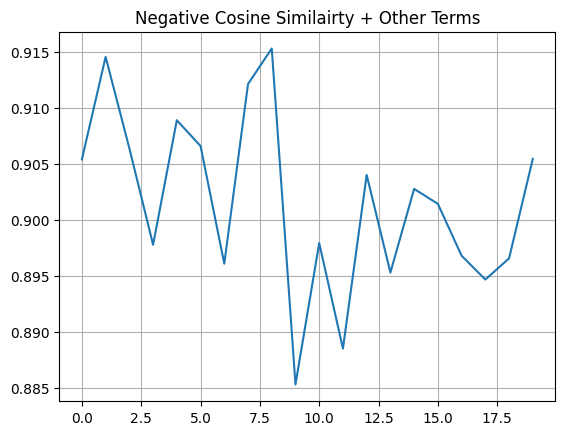

In [ ]:
num_training_samples = 9
steps = EPOCHS * (num_training_samples // BATCH_SIZE)
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.03, decay_steps=steps
)
# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=5, restore_best_weights=True
)
# Compile model and start training.
simsiam = SimSiam(get_encoder(), get_predictor(), POINT_CLOUD())
simsiam.compile(optimizer=tf.keras.optimizers.Adam(0.001))
history = simsiam.fit(ssl_ds, epochs=20, batch_size=1)

# Visualize the training progress of the model.
plt.plot(history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similairty + Other Terms")
plt.show()